In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import HUXt as H
import astropy.units as u
%matplotlib inline

In [2]:
# Set up HUXt1D to run a 5 day simulation of Carrington rotation 2000, and output model data every 4 timesteps (about 35min)
cr_num = 2000
lon = 0.0
model1D = H.HUXt1D(cr_num=cr_num, lon=lon, simtime=5, dt_scale=4)

# Get a list of CMEs with different launch longitudes and times
cme_list=[]
n_cme = 3
launch_lons = [0, 5, 10]
daysec = 86400
launch_times = [(0.25 + i*4/n_cme)*daysec for i in range(n_cme)]
               
for lon, t_launch in zip(launch_lons, launch_times):
    cme = H.ConeCME(t_launch=t_launch, longitude=lon, width=30, v=1000, thickness=5)
    cme_list.append(cme)
    
# Run HUXt1D for these cmes, save to file 
tag = 'test'
model1D.solve(cme_list, save=True, tag=tag)

In [3]:
# Set up HUXt2D to run a simulation with the same parameters.
model2D = H.HUXt2D(cr_num=cr_num, simtime=5, dt_scale=4)

# Run for the same list of cmes, save to file 
tag = 'test'
model2D.solve(cme_list, save=True, tag=tag) 

# Make an MP4 of the solution with CME
model2D.animate('cme', tag)

t:   0%|                                                                             | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2000_test_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2000_test_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR2000_test_movie.mp4


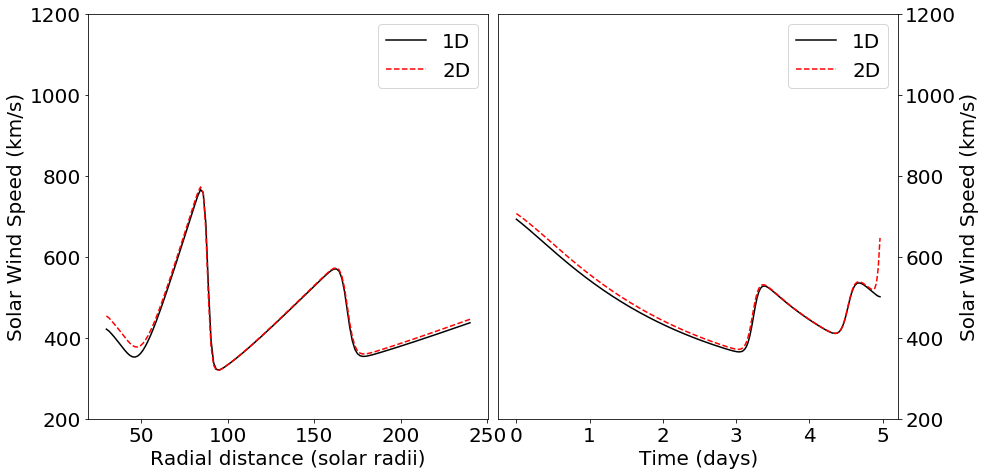

In [4]:
# Show both solutions match along the selected longitude
# Find index of the selected longitude, a time, and approx 1AU.
id_lon = np.argmin(np.abs(model2D.lon.value - model1D.lon.value))
id_t = 100
id_r = np.argmin(np.abs(model2D.r.value - 215))

fig, ax = plt.subplots(1,2, figsize=(12.5,6.25))
ax[0].plot(model1D.r, model1D.v_grid_cme[id_t, :], 'k-', label='1D')
ax[0].plot(model2D.r, model2D.v_grid_cme[id_t, :, id_lon], 'r--', label='2D')

ax[1].plot(model1D.time_out.to('day'), model1D.v_grid_cme[:, id_r], 'k-', label='1D')
ax[1].plot(model2D.time_out.to('day'), model2D.v_grid_cme[:, id_r, id_lon], 'r--', label='2D')

for a in ax:
    a.legend()
    a.set_ylim(200,1200)
    a.set_ylabel('Solar Wind Speed (km/s)')
    
ax[0].set_xlabel('Radial distance (solar radii)')
ax[1].set_xlabel('Time (days)')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
    
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.025)

In [5]:
# Get a list of CMEs with different launch longitudes and times
v_boundary = 400 * np.ones(128)
v_boundary[20:40] = 600
v_boundary[80:100] = 700
v_boundary = v_boundary * (u.km/u.s)
lon = 0.0
model1D = H.HUXt1D(v_boundary=v_boundary, lon=lon, simtime=5, dt_scale=4)
    
# Run HUXt1D for these cmes, save to file 
tag = 'test_vb'
model1D.solve(cme_list, save=True, tag=tag)

(<Figure size 1008x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e391edb0f0>)

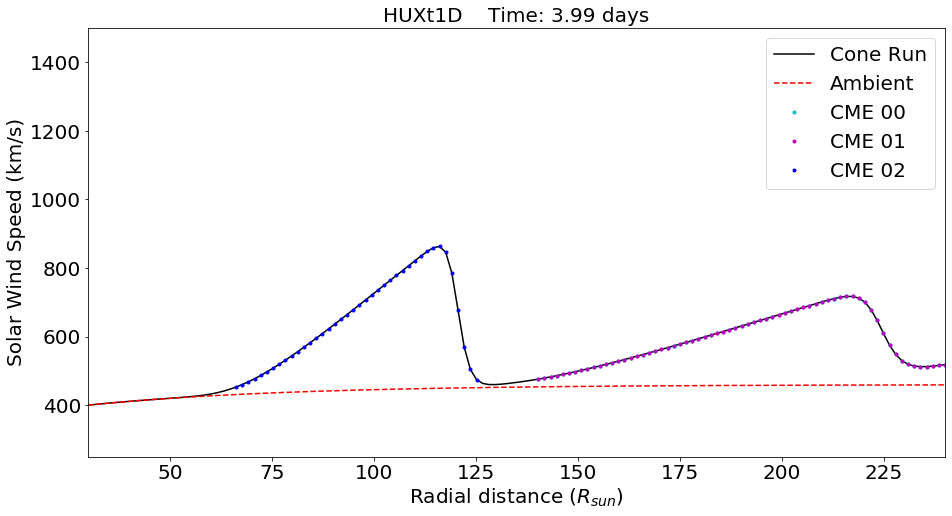

In [6]:
model1D.plot_radial((4*u.day).to(u.s), 'both')

In [7]:
model2D = H.HUXt2D(v_boundary=v_boundary, cr_num=cr_num, simtime=5, dt_scale=4)
model2D.solve(cme_list)
model2D.animate('ambient','ambient')
model2D.animate('cme','cme')

t:   1%|▌                                                                    | 2/240 [00:00<00:20, 11.59it/s, now=None]

Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR9999_ambient_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR9999_ambient_movie.mp4



t:   0%|                                                                             | 0/240 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR9999_ambient_movie.mp4
Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR9999_cme_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR9999_cme_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_CR9999_cme_movie.mp4
